In [ ]:
# BMI 계산 후 레이블 리턴하는 함수
# bmi = kg / m * m
#   18.5 미만 : thin
#   25 미만   : normal
#   25 이상   : fat

# csv 파일 생성

# 데이터 무작위 생성
# {thin : ?, normal:?, fat:?}

import random

def calc_bmi(h,w):
  bmi = w/ (h/100) ** 2
  if (bmi<18.5) : return 'thin'
  elif (bmi<25) : return 'normal'
  return 'fat'

f = open('bmi.csv','w',encoding='UTF-8')
f.write('height,weight,label\n')

count = {'thin':0, 'normal':0,'fat':0}

for i in range(20000):
  h = random.randint(120,200)
  w = random.randint(30,90)
  label = calc_bmi(h,w)
  count[label] += 1

  f.write(f"{h},{w},{label}\n")
f.close()
print(count)

{'thin': 6215, 'normal': 5309, 'fat': 8476}


In [ ]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
# csv 파일 읽어오기
csv = pd.read_csv('bmi.csv')
print(csv.shape)
csv.head()

(20000, 3)


,height,weight,label
0,137,63,fat
1,180,49,thin
2,174,32,thin
3,181,45,thin
4,162,48,thin


In [ ]:
# 키와 몸무게 기초통계량 확인
csv.describe()

,height,weight
count,20000.000000,20000.000000
mean,159.994200,60.076300
std,23.331433,17.699823
min,120.000000,30.000000
25%,140.000000,45.000000
50%,160.000000,60.000000
75%,180.000000,76.000000
max,200.000000,90.000000


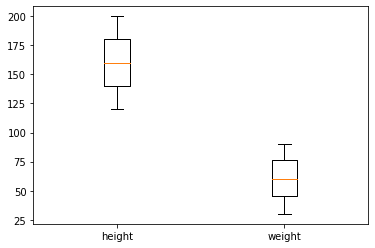

In [ ]:
# boxplot으로 h,w 분포 확인
import matplotlib.pyplot as plt

plt.boxplot([csv['height'],csv['weight']], labels=['height','weight'])
plt.show()

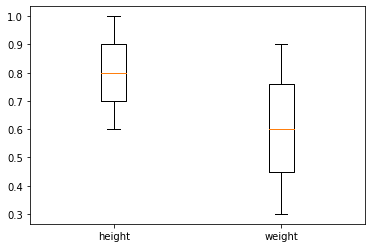

In [ ]:
# 복제본
csv1 = csv.copy()

# 키가 2미터 넘지 않고, 몸무게가 100키로 넘지않는다는 가정
# 정규화
csv1['height'] = csv1['height']/200
csv1['weight'] = csv1['weight']/100
# boxplot으로 분포화 잘 되었는지 확인
plt.boxplot([csv1['height'],csv1['weight']],labels=['height','weight'])
plt.show()

In [ ]:
# 레이블을 배열로 변환
# str -> One-Hot Encoding으로 converting
# thin : [1,0,0], normal : [0,1,0], fat : [0,0,1]
ohe = {'thin':[1,0,0],'normal':[0,1,0],'fat':[0,0,1]}
# One-Hot Encoding으로 바꾼 컬럼을 하나 더 생성
csv1['label_ohe'] = csv1['label'].apply(lambda x : np.array(ohe[x]))
# .apply() : 사용자가 정의내린 함수를 브로드캐스팅 하는 용도
csv1

,height,weight,label,label_ohe
0,0.685,0.63,fat,"[0, 0, 1]"
1,0.900,0.49,thin,"[1, 0, 0]"
2,0.870,0.32,thin,"[1, 0, 0]"
3,0.905,0.45,thin,"[1, 0, 0]"
4,0.810,0.48,thin,"[1, 0, 0]"
...,...,...,...,...
19995,0.780,0.34,thin,"[1, 0, 0]"
19996,0.645,0.83,fat,"[0, 0, 1]"
19997,0.870,0.32,thin,"[1, 0, 0]"
19998,0.730,0.54,fat,"[0, 0, 1]"


In [ ]:
# 테스트를 위한 데이터 분리 (테스트용 데이터)

# 아래의 5000개를 테스트 데이터로 분리
test_csv = csv1[15000:]
test_pat = test_csv[['height','weight']]
test_ans = list(test_csv['label_ohe'])

print(test_pat.head()) # 문제지
print(test_ans[:5])    # 정답지

       height  weight
15000   0.680    0.31
15001   0.815    0.55
15002   0.680    0.64
15003   0.770    0.56
15004   0.970    0.33
[array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([0, 1, 0]), array([1, 0, 0])]


In [ ]:
# tensorflow의 학습모델 구성
tf.reset_default_graph()
# 기존에 생성된 데이터 플로우 그래프를 모두 삭제하고 reset시켜서 중복이 되는걸 막아줌

In [ ]:
# 신경망 구성

# 데이터 플로우 그래프 구축하기
# placeholder 생성

# 키와 몸무게 데이터 넣기 (height, weight : 2개의 feature)
x = tf.placeholder(tf.float32,[None,2])
# 정답 label
y_ = tf.placeholder(tf.float32, [None,3])

# 변수 선언
W = tf.Variable(tf.zeros([2,3])) # 가중치
b = tf.Variable(tf.zeros([3]))     # 바이어스(bias) : 뉴런의 활성화를 조절

# 소프트맥스 회귀 : one-hot encoding과 연결하기 위해서 0~1 사이의 숫자로 바꾸는 역할
y = tf.nn.softmax(tf.matmul(x, W) + b) # 내적곱

# 손실함수의 Cross Entropy : 분류 모델이 얼마나 잘 수행되는지 측정하기 위해 사용하는 지표
#    y_ * tf.log(y) 에는 데이터들의 크로스 엔트로피들의 2차원 텐서가 들어있음
#    reduce_sum() 함수는 지정된 차원에 따라서 평균을 내는 함수
# 크로스 ㅇ네트로피에서는 실제값과 예측값이 맞는 경우 0으로 수렴하고,
# 값이 틀릴 경우에는 값이 커지기 때문에 -> 실제값과 예측값의 차이를 줄이기 위한 엔트로피
ce = -tf.reduce_sum(y_ * tf.log(y))

# 최적화 : 경사하강법 (함수의 기울기(경사)를 구하고, 경사의 절대값이 낮은 쪽으로 이동시켜서
#                  극값에 이를 때까지 반복시키는 것)
optimizer = tf.train.GradientDescentOptimizer(0.01) # 0.01 : 학습 계수 (하강 간격)
# Gradient : 경사 / Descent : 내려감 >> 경사를 따라 내려가는 알고리즘 (기울기)
# Optimizer : 각각의 변수에 기대되는 값과 손실의 도함수의 정도에 따라서 변수의 값을 변경해주는 것 
#     도함수 : 원래 함수를 미분해서 얻어낸 햄수 >> 어떤 점에서의 기울기
# 텐서플로우 : 도함수를 자동으로 만들어 줌

# 가중치, 편차를 보정
optimizer1 = optimizer.minimize(ce)

# 정답률 구하기
# tf.argmax(y,1)   : 모델이 생각할 때 각 데이터에 가장 적합하다고 판단한 레이블
# tf.argmax(y_, 1) : 실제 레이블
# tf.equal()를 이용해 예측이 맞았는지 확인
predict = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))

# 평균 구하기 (차원을 낮춰서)
score = tf.reduce_mean(tf.cast(predict, tf.float32))

print(predict)
print(score)

Tensor("Equal:0", shape=(None,), dtype=bool)
Tensor("Mean:0", shape=(), dtype=float32)


In [ ]:
# 실제 실행이 이루어지는 Session

with tf.Session() as sess:
  f_bmi = tf.summary.FileWriter('info_bmi',graph=sess.graph) # 그래프
  sess.run(tf.global_variables_initializer()) # 변수 초기화 하기

  # 학습시키기 - 3500번
  for step in range(3500):
    # 0 ~ 14999까지 100개씩 학습
    i = (step * 100) % 14000

    # 학습이 되는 행을 추출
    rows = csv1[1 + i : 1 + i + 100]

    # feautre_data, label_data를 분리
    xf = rows[['height','weight']] # (x_train)
    yl = list(rows['label_ohe']) # (y_train)

    feed_dict = {x : xf, y_ : yl}
    sess.run(optimizer1, feed_dict=feed_dict)

    # 학습된 모델을 가지고 test를 진행할 때 콘솔에서 진행상황 확인 할 수 있도록
    if step % 500 == 0: # 500개마다
      ce1 = sess.run(ce, feed_dict={x:test_pat, y_:test_ans})
      ac = sess.run(score, feed_dict={x:test_pat, y_:test_ans})
      print('단계=',step, '크로스엔트로피=',ce1,'정확도=',ac)
  
  # 최종 정답률 (정확도)
  ac = sess.run(score, feed_dict={x:test_pat, y_:test_ans})
  print('정확도=',ac)


단계= 0 크로스엔트로피= 5376.7583 정확도= 0.4206
단계= 500 크로스엔트로피= 2492.04 정확도= 0.8226
단계= 1000 크로스엔트로피= 2034.8376 정확도= 0.9018
단계= 1500 크로스엔트로피= 1790.6154 정확도= 0.9272
단계= 2000 크로스엔트로피= 1634.5431 정확도= 0.9274
단계= 2500 크로스엔트로피= 1512.7258 정확도= 0.9534
단계= 3000 크로스엔트로피= 1424.5261 정확도= 0.9582
정확도= 0.9588
